<h1 align="center" style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">Natural Language Processing: Classification of News Articles</h1>

This project coveres  specific tasks such as tokenizatination, stopword removal, lematization, vectorization etc. and the use of classification metrics like K-NN, RNN, 1D-CNN  to achieve a befitting accuracy score.

<a id='table_of_contents'></a>
<h2 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">Table of Contents</h2>

1. <a href="#import" style="text-decoration: None">Import Libraries</a>
2. <a href="#load_data" style="text-decoration: None">Load Dataset</a>
3. <a href="#preview" style="text-decoration: None">Dataset Preview</a>
4. <a href="#eda" style="text-decoration: None">Exploratory Data Analysis</a>
5. <a href="#preprocessing" style="text-decoration: None">Data Preprocessing</a>
    - <a href="#todo1" style="text-decoration: None">TODO 1: Remove Residual HTML Codes  and News Agencies Names</a>
    - <a href="#todo2" style="text-decoration: None">TODO 2: Apply Lemmatization to Simplify Grammatical Word Variations</a>
6. <a href="#baseline_model" style="text-decoration: None">Baseline Model: Recurrent Neural Network classifier with Keras and Tensorflow</a>
7. <a href="#todo3" style="text-decoration: None">TODO 3: Creating Example Predictions</a>
8. <a href="#todo4" style="text-decoration: None">TODO 4: Create a new model</a>
9. <a href="#todo5" style="text-decoration: None">TODO 5: Discussion</a>

<a id="import"></a>
<h2 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">1. Import Libraries</h2>

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')  # it downloads vital files and resources needed when using WordNet features withing NLTK-based applications
nltk.download('punkt')   # the downladed file contains trained models that the tokenizer uses to tokenize text into sentenses

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import (
    TextVectorization,
    Embedding,
    LSTM,
    Bidirectional,
    Dense,
    Dropout,
    Conv1D,
    GlobalMaxPooling1D
)
import tensorflow.keras
from tensorflow.keras.models import Sequential

# Use random see for code reusability - https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
import random
random.seed(0)  #this makes it possible to reproduce the same sequence of numbers everytime on runs the program.
np.random.seed(0)
tf.random.set_seed(0)

pd.set_option('display.max_colwidth', 100)   # it is used to set maximum column width displayed when printing the datafram columns

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id="load_data"></a>
<h2 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">2. Load Dataset</h2>

In [ ]:
pd.set_option('display.max_colwidth', 300) # it is used to set maximum column width displayed when printing the dataframe columns

In [ ]:
# Importing the dataset
# train_data = pd.read_csv("news_dataset/train.csv")
# test_data = pd.read_csv("news_dataset/test.csv")

train_data = pd.read_csv("/content/drive/MyDrive/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/test.csv")

In [ ]:
# substract 1 from the target variable for both, train and test data
train_data["Class Index"] = train_data["Class Index"] - 1
test_data["Class Index"] = test_data["Class Index"] - 1
label_names = ["World", "Sports", "Business", "Sci/Tech"] # 0 is "World", 1 is "Sports", ...

<a id="preview"></a>
<h2 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">3. Dataset Preview</h2>

In [ ]:
# Show the first five rows from the training data
train_data.head(5)

,Class Index,Title,Description
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
1,2,Carlyle Looks Toward Commercial Aerospace (Reuters),"Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market."
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
3,2,Iraq Halts Oil Exports from Main Southern Pipeline (Reuters),"Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, an oil official said on Saturday."
4,2,"Oil prices soar to all-time record, posing new menace to US economy (AFP)","AFP - Tearaway world oil prices, toppling records and straining wallets, present a new economic menace barely three months before the US presidential elections."


In [ ]:
# Print the number of instances in the training data
print(train_data.shape)

(120000, 3)


In [ ]:
# Print the number of instances in the test data
print(test_data.shape)

(7600, 3)


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [ ]:
#The dataset does not contain any null values

In [ ]:
# Check if there are duplicated entries
train_data.duplicated().sum()

0

In [ ]:
#The dataset does not contain duplicates

<a id="eda"></a>
<h2 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">4. Exploratory Data Analysis</h2>

In [ ]:
sns.set_style("whitegrid") # Use a white background with grid for plotting

<h3 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">4.1. Class Distribution</h3>

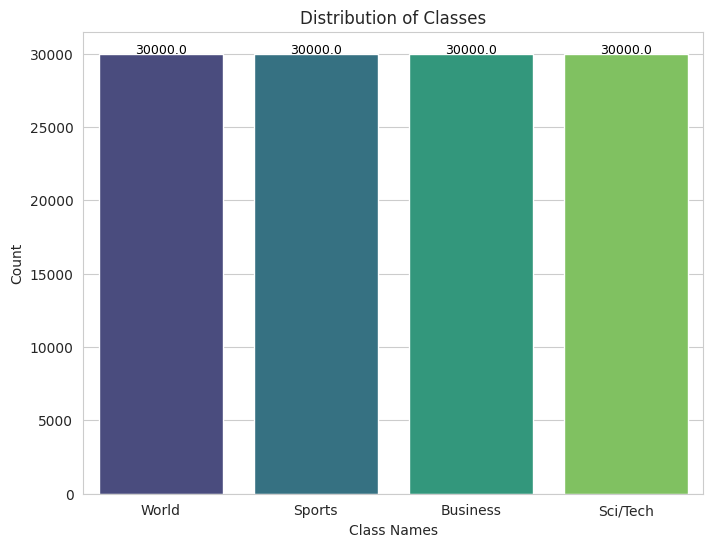

In [ ]:
# Create a bar chart for visualizing the number of instances in each class
plt.figure(figsize=(8, 6))
sns.countplot(x='Class Index', data=train_data, order=range(len(label_names)), palette='viridis')

# Add counts on top of each bar
for p in plt.gca().patches:
    plt.gca().annotate(f'\n{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='baseline', fontsize=9, color='black')

# Set x-axis labels to class names
plt.xticks(range(len(label_names)), label_names)

plt.xlabel('Class Names')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.show()

In [ ]:
#Each target class has an equal number of instances.

<h3 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">4.2. Word Cloud</h3>

In [ ]:
from wordcloud import WordCloud    #It allows us to create word clouds in python code

In [ ]:
def generate_word_cloud(data, class_index, label_names):
    """
    Generate and display a word cloud for a specific class based on the given data.

    Args:
    - data (pd.DataFrame): The DataFrame containing the data with a 'Class Index' column and a 'Description' column.
    - class_index (int): The index of the class for which the word cloud is to be generated.
    - label_names (list): A list of class labels corresponding to the class indices.

    Returns:
    None
    """
    # Filter data for a specific class
    class_data = data[data['Class Index'] == class_index]

    # Concatenate text from the filtered data
    class_text = ' '.join(class_data['Description'])

    # Generate word cloud for the class
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(class_text)

    # Display word cloud with class label
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(label_names[class_index])
    plt.axis('off')
    plt.show()

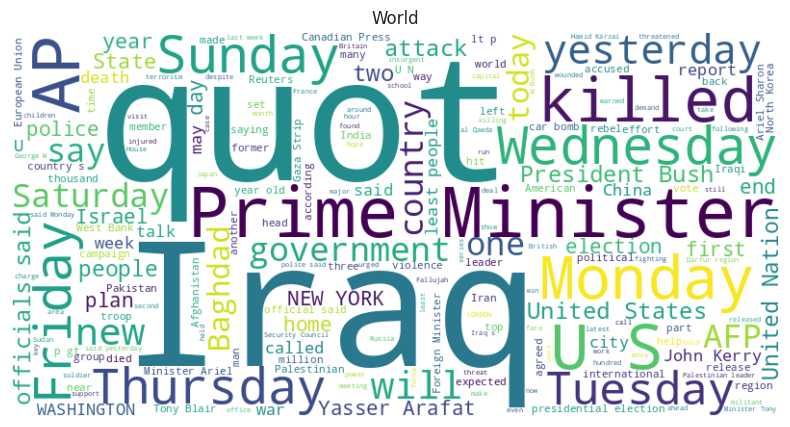

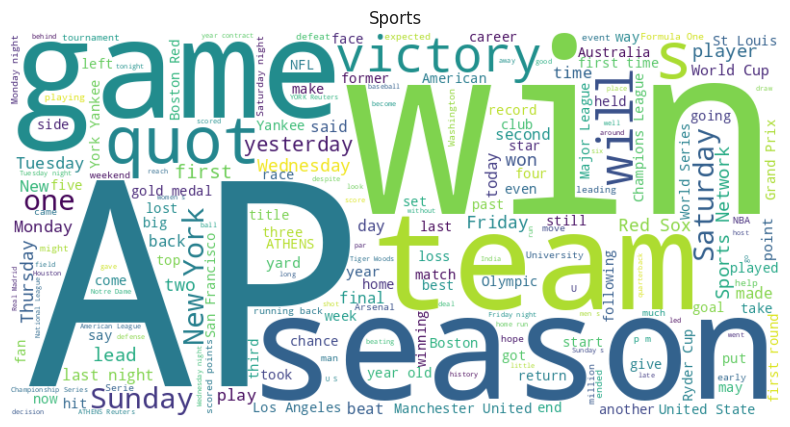

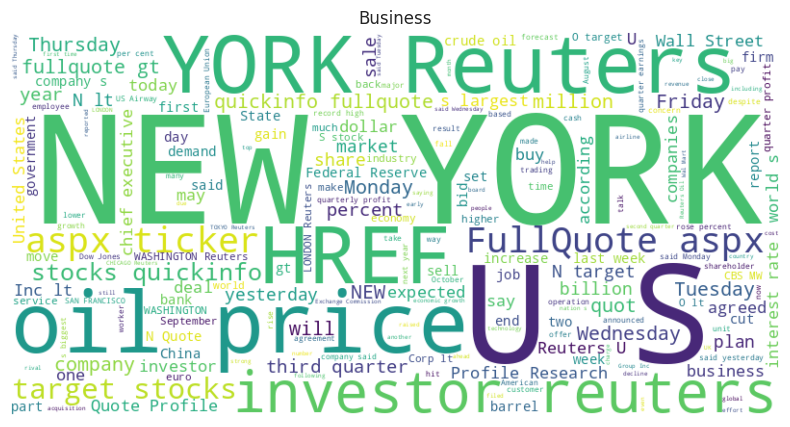

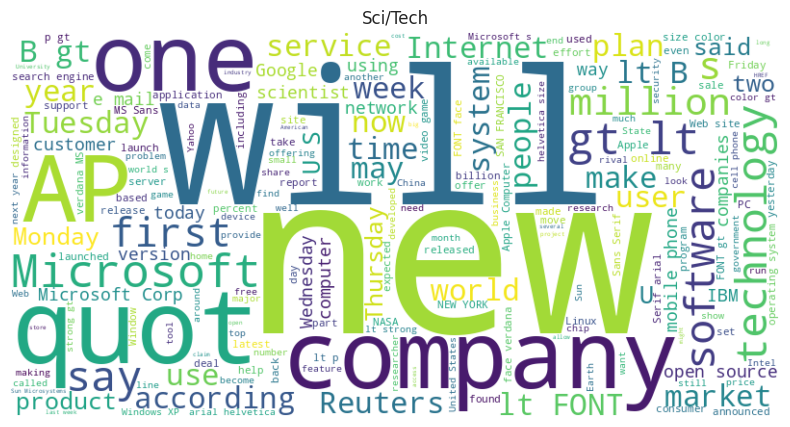

In [ ]:
label_names = ["World", "Sports", "Business", "Sci/Tech"]

# Iterate through class indices and generate word clouds
for class_index in range(len(label_names)):
    generate_word_cloud(train_data, class_index, label_names)

<a id="preprocessing"></a>
<h2 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">5. Data Preprocessing</h2>

The names of news agencies (if they exist) are typically enclosed in brackets at the end of the news 'Title', for example, 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)', 'Oil prices soar to an all-time record, posing a new menace to the US economy (AFP),' etc.

An apparent strategy involves extracting all words enclosed in brackets at the end of each sentence. However, a drawback of this method is that some words, not necessarily news agency names, may match this pattern. To address this issue, we adopt a solution by keeping a record of the occurrences of such words and discarding them if the count is less than 2 - we simply assume they are coincidental.

**New Agencies Names**

In [ ]:
# Define regex pattern to match text inside brackets at the end of each sentence
pattern = r'\(([A-Z][^\)]+)\)$'

# Initialize an empty dictionary to store the frequncy of extracted news agencies names
news_agencies = {}

# Iterate through each news title
for sentence in train_data["Title"].tolist():
    # Use findall to extract matches from the current string
    tentative_agency = re.findall(pattern, sentence)

    assert len(tentative_agency) <= 1  # Confirm the search returns at most one result

    # If search doesn't return an empty list - do
    if len(tentative_agency) == 1:
        if tentative_agency[0] in news_agencies:
            news_agencies[tentative_agency[0]] += 1 # increment counter if result already exist in the dictionary
        else:
            news_agencies[tentative_agency[0]] = 1 # add result to the dictionary if it does not exit

# Filter news agencies with count greater than 1
news_agencies = {key: count for key, count in news_agencies.items() if count > 1}

# Print the dictionary of news agencies
print(news_agencies)

# Discard frequencies and retain only a list of news agencies names
news_agencies = [k for k, v in news_agencies.items()]

{'Reuters': 4225, 'AFP': 1955, 'AP': 7692, 'USATODAY.com': 142, 'Forbes.com': 85, 'TechWeb': 65, 'PC World': 190, 'MacCentral': 100, 'SPACE.com': 148, 'Ziff Davis': 139, 'Canadian Press': 451, 'Chicago Tribune': 16, 'Los Angeles Times': 18, 'The Motley Fool': 33, 'NewsFactor': 253, 'Correct': 10, 'Update5': 44, 'Editor and Publisher': 11, 'ESP': 2, 'Update2': 195, 'Update1': 280, "Investor's Business Daily": 46, 'Update4': 77, 'Update3': 103, 'SiliconValley.com': 66, 'Update6': 17, 'Update7': 10, 'InfoWorld': 108, 'Getty Images': 19, 'Update10': 2, 'TheDeal.com': 34, 'FT.com': 34, 'BusinessWeek Online': 18, 'Update8': 4, 'Update9': 5, 'AdWeek.com': 11, 'U.S. News   World Report': 3, 'Sat': 2, 'OT': 2, 'New York Post': 4, 'Update12': 2, 'LEAD': 2, 'Variety': 3, "Except When It's Not": 2, 'The Sporting News': 2, 'Schilling': 3}


**Residual HTML**

After manually reviewing a sample of about 20 rows in the 'Description' column, it was noted that there are inconsistencies in the capitalization of HTML tags such as 'HREF' and keywords such as 'WWW.' Additionally, these links are typically enclosed within "&lt" and "&gt" entity character. Some of these links serve as advertisements, while others provide minimal information to the overall text.

Therefore, without a substantial loss of information, it is possible to eliminate all characters occurring between the "&lt" and the "&gt" entity.

After removing all characters between the said entity characters, the next step will then be to remove all residual links (www, http, https,...) using the normal convention.    

In [ ]:
# The code below prints the first two entries from "Description" column which contains the word "href"
count = 0
for text in train_data["Description"].tolist():
    if 'href' in text:
        print(text, end='\n\n')
        count += 1
    if count == 2:
        break

Advanced Micro Devices Inc.'s (AMD Inc.'s) 90-nanometer notebook processors are on their way to customers, according to a research note published by Goldman Sachs   Co. Thursday.&lt;p&gt;ADVERTISEMENT&lt;/p&gt;&lt;p&gt;&lt;img src="http://ad.doubleclick.net/ad/idg.us.ifw.general/ibmpseries;sz=1x1;ord=200301151450?" width="1" height="1" border="0"/&gt;&lt;a href="http://ad.doubleclick.net/clk;9824455;9690404;u?http://ad.doubleclick.net/clk;9473681;9688522;d?http://www.ibm.com/servers/eserver/pseries/campaigns/boardroom/index.html?ca=pSeries met=boardroom me=E P_Creative=P_InfoW_RSS"&gt;Introducing IBM eServer p5 systems.&lt;/a&gt;&lt;br/&gt;Powered by IBMs most advanced 64-bit microprocessor (POWER5(tm)), p5 systems can run UNIX and Linux simultaneously. Learn more about eServer p5 systems.&lt;/p&gt;

CAP DE BON DSIR, Quebec A few miles from this spit along the pink granite coast of the Gulf of St. Lawrence, there is a sheltered cove that has witnessed the full span of the human relatio

In [ ]:
#As pointed out earlier, majority of the redundant html codes lies between the "&lt" and "&gt" entity character.

<a id="todo1"></a>

<h3 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">5.1. TODO 1: Remove News Agencies Names and Residual HTML Codes</h3>

**The function below removes News Agencies Names and Residual HTML Codes**

In [ ]:
def preprocess_text(string):
    """
    Clean the given text by removing specific patterns and content.

    Args:
    - string (str): The text description to be cleaned.

    Returns:
    str: The cleaned text.
    """
    # TODO 1: REMOVE http (html, ...) and news agencies names (Reuters, AP, ...)

    # Remove content between &lt; and &gt;
    string = re.sub(r'&lt;.*?&gt;', '', string)

    # Remove URLs of the form www
    string = re.sub(r'www\.', '', string)

    # Remove URLs of the form http://, HTTP://, https://, HTTPS://
    string = re.sub(r'https?://', '', string, flags=re.IGNORECASE)

    # Remove occurrences of the word 'quot'
    string = re.sub(r'\bquot\b', '', string, flags=re.IGNORECASE)

    # Remove news agency names
    for agency in news_agencies:
        description = string.replace(agency, '')

    string = string.lower()
    string = string.replace("'", " ")
    string = string.replace("\\", " ")
    string = re.sub(r"[^a-zA-Z]", " ", string)

    return string


train_data['Description'] = train_data['Description'].apply(preprocess_text)
test_data['Description'] = test_data['Description'].apply(preprocess_text)

Convert dataframes to lists (needed for further functions).

In [ ]:
train_data_list = train_data["Description"].tolist()
test_data_list = test_data["Description"].tolist()
train_labels_list = train_data["Class Index"].tolist()
test_labels_list = test_data["Class Index"].tolist()

Create validation set (taking out 20% of test set)

In [ ]:
(train_data_list, validation_data_list,
 train_labels_list, validation_labels_list) = train_test_split(train_data_list, train_labels_list, test_size=0.2, stratify=train_labels_list)

In [ ]:
print(f"The length of the training data is {len(train_data_list)}")
print(f"The length of the validation data is {len(validation_data_list)}")
print(f"The length of the test data is {len(test_data_list)}")

The length of the training data is 96000
The length of the validation data is 24000
The length of the test data is 7600


In [ ]:
# Check feature-label length consistency to avoid future index errors
assert len(train_data_list) == len(train_labels_list)
assert len(validation_data_list) == len(validation_labels_list)
assert len(test_data_list) == len(test_labels_list)

### Removing Stop Words
Remove stopwords from the *stopword* corpus.

In [ ]:
nltk.download("stopwords")
def remove_stopwords(data_list):
    stopword_list = stopwords.words("english")
    for i in range(len(data_list)):
        data_list[i] = " ".join(
            [word for word in data_list[i].split() if word not in (stopword_list)]
        )
    return data_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_data_list = remove_stopwords(train_data_list)
validation_data_list = remove_stopwords(validation_data_list)
test_data_list = remove_stopwords(test_data_list)

<a id="todo2"></a>

<h3 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">5.2. TODO 2: Apply lemmatization to simplify grammatical word variations.</h3>

The major difference between stemming and lemmatization is that stemming just removes or stems the last few characters of a word, often leading to incorrect meanings and spelling while lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma. [5,6].

In this scenario, lemmatization is preferable over stemming as it preserves the semantic meaning of words, capturing subtleties in sentiment expression more accurately.

Before performing lemmatization however, the following preprocessing techniques were done

- Tokenization
- Punctuations removal

In [ ]:
def lemmatization(data_list):
    lemmatizer = WordNetLemmatizer()
    for i in range(len(data_list)):
        # Perform tokenization
        tokens = word_tokenize(data_list[i])

        # Remove punctuation
        tokens = [word for word in tokens if word.isalnum()]

        # Perform Lemmatization
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        # Join tokens back into a string
        processed_string = ' '.join(tokens)

        # Add processed_string back to data_list
        data_list[i] = processed_string

    return data_list

In [ ]:
train_data_list = lemmatization(train_data_list)
validation_data_list = lemmatization(validation_data_list)
test_data_list = lemmatization(test_data_list)

<a id="baseline_model"></a>

<h2 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">6. Baseline Model: Recurrent Neural Network classifier with Keras and Tensorflow</h2>

One-hot encode the labels (0 -> 0001, 1 -> 0010, ...) to match NN classifier head output.

In [ ]:
# the labels are of value 0, 1, 2, 3. We need to convert them to one-hot encoded vectors
train_labels = tensorflow.keras.utils.to_categorical(np.array(train_labels_list), num_classes=4)
validation_labels = tensorflow.keras.utils.to_categorical(np.array(validation_labels_list), num_classes=4)
test_labels = tensorflow.keras.utils.to_categorical(np.array(test_labels_list), num_classes=4)
print(train_labels.shape)

(96000, 4)


First we use the TextVectorization layer to convert the text to a sequence of integers. You can read about how this works. [8] Tensorflow


In [ ]:
# this will create a vocabulary of the top 2500 words and then convert the text to a sequence of numbers
vocab_size = 2500 # how many of the most frequent words to keep
sequence_length = 30 # how many words we use to represent a description
vectorizer = TextVectorization(max_tokens=vocab_size, output_sequence_length=sequence_length)
# fit the vectorizer on the training data (find the most common words and assign values to them)
vectorizer.adapt(train_data_list)
# show the first 100 selected words
print(vectorizer.get_vocabulary()[:100])

['', '[UNK]', 'said', 'new', 'u', 'year', 'reuters', 'company', 'two', 'first', 'ap', 'monday', 'world', 'wednesday', 'one', 'tuesday', 'thursday', 'inc', 'friday', 'game', 'week', 'state', 'yesterday', 'last', 'york', 'time', 'million', 'three', 'day', 'president', 'corp', 'oil', 'price', 'say', 'sunday', 'government', 'would', 'month', 'united', 'official', 'group', 'people', 'today', 'service', 'second', 'security', 'could', 'team', 'season', 'percent', 'iraq', 'saturday', 'night', 'plan', 'third', 'next', 'software', 'market', 'minister', 'quarter', 'country', 'business', 'high', 'microsoft', 'internet', 'announced', 'back', 'report', 'billion', 'international', 'computer', 'four', 'technology', 'washington', 'stock', 'american', 'may', 'share', 'win', 'city', 'system', 'sale', 'network', 'leader', 'former', 'top', 'record', 'home', 'victory', 'news', 'nation', 'election', 'end', 'player', 'n', 'maker', 'giant', 'open', 'european', 'league']


In [ ]:
# vectorize the training data (replace words by their associated values)
train_data_vectorized = vectorizer(train_data_list)
# vectorize the validation data
validation_data_vectorized = vectorizer(validation_data_list)
# vectorize the test data
test_data_vectorized = vectorizer(test_data_list)
# this shape shows that we have our 96000 training examples, each as a vector of 30 integers
print(train_data_vectorized.shape)

(96000, 30)


In [ ]:
# see how a vectorized news description looks like
print(f"Original news description: {train_data_list[1]}")
print(f"Vectorized news description: {train_data_vectorized[1]}")

Original news description: sbc communication pay million microsoft software used deliver tv programming high speed data line
Vectorized news description: [2399  426  302   26   63   56  310 1962  658    1   62  582  218  225
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


From observation the vectorized news description has been padded with zeros since we specified the sequence length as 30.

Hence, RNN will be built.

We use an *Embedding layer* to convert the integer sequences to embeddings.[3,9].

The Bidirectional layer takes the input and passes it forwards and backwards through the LSTM (Long-Short Term Memory) layer. It allows the network to learn the context of the sentence in both directions, so information from both previous and following words is taken into account.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          80000     
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 96900 (378.52 KB)
Trainable params: 96900 (378.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
750/750 [==============================] - 19s 22ms/step - loss: 0.4642 - accuracy: 0.8268 - val_loss: 0.3344 - val_accuracy: 0.8844
Epoch 2/5
750/750 [==============================] - 16s 22ms/step - loss

<Axes: >

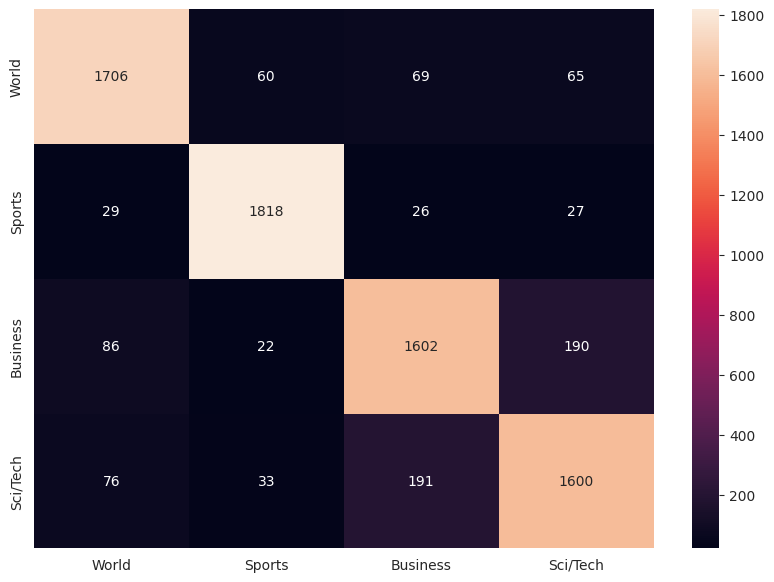

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(4, activation="softmax"))

model.summary()

# compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit the model
model.fit(
    train_data_vectorized,
    train_labels,
    epochs=5,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels),
)

# predict the labels on the test data
rnn_predictions = model.predict(test_data_vectorized)
# since predictions are one-hot encoded, we convert them to an int label taking the output with higher value
rnn_predictions = np.argmax(rnn_predictions, axis=1)

# calculate the accuracy score
accuracy = accuracy_score(test_labels_list, rnn_predictions)
print("Test Set Accuracy: ", accuracy)
# create a confusion matrix
cm = confusion_matrix(test_labels_list, rnn_predictions)
# plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)

<a id="todo3"></a>

<h2 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">7. TODO 3: Creating Example Predictions</h2>

Test the model. Create some fresh sample news (copy them from a news site like BBC) then see if the model can predict the correct labels. Use one example per class.

Also, find one example that gets misclassified and briefly discuss here why it might happen:

#### Sample news were appended in the following order:

-  "World": https://www.bbc.com/news/world-africa-67850563
- "Sports": https://www.bbc.com/sport/football/67818350
- "Business": https://www.bbc.com/news/business-67785266
- "Sci/Tech": https://www.bbc.com/news/technology-67801091

- Misclassified: https://www.bbc.com/news/business-67657895

In [ ]:
sample_news = list()
# TODO 3: create some fresh sample news (copy them from a news site like BBC) then see if the model can predict the correct labels
# Use one example per class
sample_news.append("President Félix Tshisekedi has been declared the winner of Democratic Republic of Congo's election, which has been condemned as a 'sham' by several opposition candidates demanding a rerun.")
sample_news.append("Tom Cannon scored twice - his first goals for Leicester City - as they resoundingly beat Huddersfield Town to move 10 points clear at the top of the Championship table.")
sample_news.append("An increase in the cost of domestic energy in England, Wales and Scotland has taken effect, adding pressure to household budgets in the new year.")
sample_news.append("China is to bring in new rules that will limit the amount of money and time that people can spend on video games.")
# Also, find one example that gets misclassified and discuss why it might happen in the markdown above.
sample_news.append("The UK's competition watchdog is to look at whether Microsoft's high-value partnership with OpenAI could be considered as a merger.")

def example_prediction(sample_news):
    # preprocess the sample news
    sample_news = [preprocess_text(i) for i in sample_news]
    sample_news = remove_stopwords(sample_news)

    # If you added stemming/lemmatization, do it on sample_news as well
    # your code here
    sample_news = lemmatization(sample_news)

    # vectorize the sample news
    sample_news_vectorized = vectorizer(sample_news)

    # predict using the neural network
    prediction = model.predict(sample_news_vectorized)
    prediction = np.argmax(prediction, axis=1)
    for i in prediction:
         print("NN classifier prediction: ", label_names[prediction[i]], "News")


example_prediction(sample_news)

1/1 [==============================] - 0s 17ms/step
NN classifier prediction:  World News
NN classifier prediction:  Sports News
NN classifier prediction:  Business News
NN classifier prediction:  Sci/Tech News
NN classifier prediction:  Sci/Tech News


The misclassification of the given news article, originally about Microsoft, as a Sci/Tech news instead of Business, could be attributed to the fact that the content contains terms and context that are strongly associated with Sci/Tech domains than Business domain with respect to the training data. For example, the word cloud for Sci/Tech class has a large text for the word "Microsoft" which implies that word occurs more frequently. This suggests that during the training phase, the model may have learned a strong association between the occurrence of the word "Microsoft" and the Sci/Tech category. In fact, we can confirm that the word "Microsoft" can single-handedly affect the class output as shown below.

In [ ]:
# Remove the word "Microsoft" from the misclassified text and check the classified class
sample_news.append("The UK's competition watchdog is to look at whether high-value partnership with OpenAI could be considered as a merger.")

example_prediction(sample_news)

1/1 [==============================] - 0s 15ms/step
NN classifier prediction:  World News
NN classifier prediction:  Sports News
NN classifier prediction:  Business News
NN classifier prediction:  Sci/Tech News
NN classifier prediction:  Sci/Tech News
NN classifier prediction:  Business News


<a id="todo4"></a>

<h2 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">8. TODO 4: Create a new model</h2>

I have attempted to improve the baseline RNN by increasing the number of layers using the following [1,2 4,7]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          80000     
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 512)         591872    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 256)         656384    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, None, 128)         164352    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                      

<Axes: >

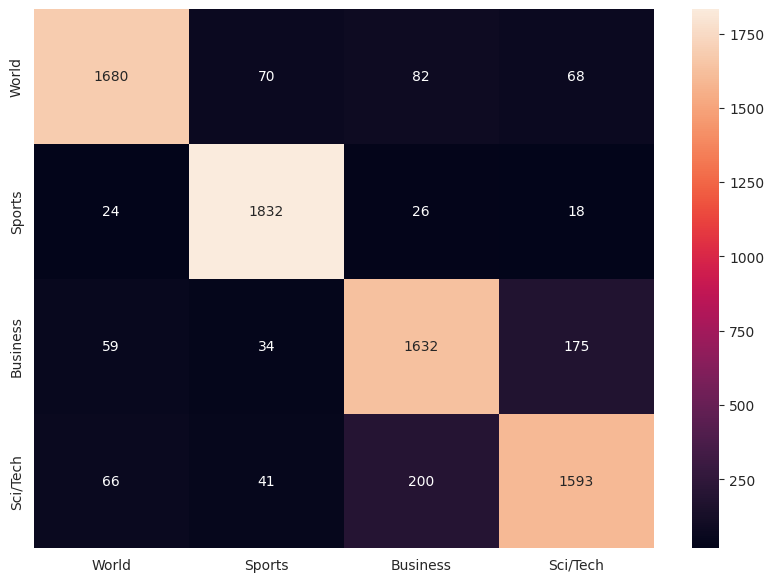

In [ ]:
# TODO 4: YOUR CODE HERE
new_model = Sequential()
new_model.add(Embedding(vocab_size, 32))
new_model.add(Bidirectional(LSTM(256, return_sequences=True)))  # First Bidirectional LSTM layer
new_model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Second Bidirectional LSTM layer
new_model.add(Bidirectional(LSTM(64, return_sequences=True)))  # Third Bidirectional LSTM layer
new_model.add(Dropout(0.5))  # Added dropout for regularization
new_model.add(Bidirectional(LSTM(32, return_sequences=True)))  # Additional Bidirectional LSTM layer
new_model.add(Bidirectional(LSTM(16)))  # Last Bidirectional LSTM layer
new_model.add(Dense(4, activation="softmax"))

new_model.summary()

# compile the model
new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit the model
new_model.fit(
    train_data_vectorized,
    train_labels,
    epochs=5,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels),
)

# predict the labels on the test data
new_rnn_predictions = new_model.predict(test_data_vectorized)
# since predictions are one-hot encoded, we convert them to an int label taking the output with higher value
new_rnn_predictions = np.argmax(new_rnn_predictions, axis=1)

# calculate the accuracy score
accuracy = accuracy_score(test_labels_list, new_rnn_predictions)
print("Test Set Accuracy: ", accuracy)
# create a confusion matrix
cm = confusion_matrix(test_labels_list, new_rnn_predictions)
# plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)

#### CNN Model

The code below uses a simple CNN architecture with one 1D convolutional layer followed by global max-pooling and dense layers.[2] .

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 32)            80000     
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            10304     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 94724 (370.02 KB)
Trainable params: 94724 (370.02 KB)
Non-trainable params: 0 (0.00 Byte)
________________

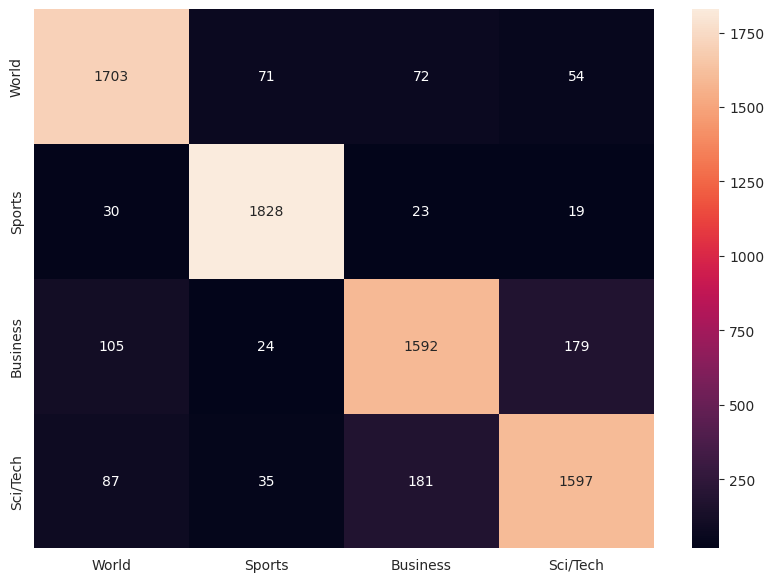

In [ ]:
# CNN Model
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocab_size, output_dim=32, input_length=sequence_length))
model_cnn.add(Conv1D(64, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(4, activation='softmax'))

model_cnn.summary()

# Compile the model
model_cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model
model_cnn.fit(
    train_data_vectorized,
    train_labels,
    epochs=5,
    batch_size=128,
    verbose=1,
    validation_data=(validation_data_vectorized, validation_labels),
)

# Predict the labels on the test data
cnn_predictions = model_cnn.predict(test_data_vectorized)
cnn_predictions = np.argmax(cnn_predictions, axis=1)

# Calculate the accuracy score
accuracy_cnn = accuracy_score(test_labels_list, cnn_predictions)
print("CNN Test Set Accuracy: ", accuracy_cnn)

# Create a confusion matrix for CNN
cm_cnn = confusion_matrix(test_labels_list, cnn_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_cnn, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)
plt.show()

### Model Comparison

**Now let us compare the performance of all the models. Baseline RNN, Multi-layered RNN and 1D-CNN**

In [ ]:
# Baseline RNN
print(classification_report(test_labels_list, rnn_predictions, target_names=label_names))

# Multi-layered RNN
print(classification_report(test_labels_list, new_rnn_predictions, target_names=label_names))

# 1D-CNN
print(classification_report(test_labels_list, cnn_predictions, target_names=label_names))

              precision    recall  f1-score   support

       World       0.90      0.90      0.90      1900
      Sports       0.94      0.96      0.95      1900
    Business       0.85      0.84      0.85      1900
    Sci/Tech       0.85      0.84      0.85      1900

    accuracy                           0.89      7600
   macro avg       0.88      0.89      0.88      7600
weighted avg       0.88      0.89      0.88      7600

              precision    recall  f1-score   support

       World       0.92      0.88      0.90      1900
      Sports       0.93      0.96      0.95      1900
    Business       0.84      0.86      0.85      1900
    Sci/Tech       0.86      0.84      0.85      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

              precision    recall  f1-score   support

       World       0.88      0.90      0.89      1900
      Sports       0.

**Accuracy:** The test set accuracies are quite close for all three models, with the Multilayered RNN having a slightly higher accuracy (88.6%) compared to the Baseline RNN (88.5%) and the 1D CNN (88.4%). However, the differences are relatively small.

**Model Size:** The Baseline RNN has the smallest number of parameters, making it more memory-efficient and potentially faster to train. The 1D CNN is also relatively lightweight compared to the Multilayered RNN, which has a significantly larger number of parameters.

<a id="todo5"></a>

<h2 style="background-color:#0b0504;color:white;border-radius: 8px; padding:12px">9. TODO 5: Discussion</h2>

Outlined below is how steps 1 to 4 may be impacting the performance of the model:

**Step 1: Cleaning the Data**

- Removing HTML code and web links, as well as eliminating news agency names, is a crucial step to ensure that the model focuses on the actual content rather than noise. It helps in creating a cleaner and more meaningful dataset for training.

**Step 2: Preprocessing Text**

- Using lemmatization, removing stop words, and converting text to lowercase are standard techniques for text preprocessing in NLP. These steps help in reducing dimensionality, focusing on the core meaning of words, and making the data more consistent.

**Step 3: Testing with Recent News**

- Testing the model with recent news is a good practice to check its generalization ability. The misclassification analysis for the Sci/Tech news shows a good understanding of potential challenges and reasons for misclassification. This step allows us to identify areas of improvement and refine the model accordingly.

**Step 4: Trying Different Model Architectures**

- Adding extra layers to the Bidirectional LSTM model is a valid approach to experiment with the architecture. In our case, the slightly improved accuracy is due to the increased number of parameters. Deeper layers can learn more abstract and high-level representations, allowing the model to understand intricate dependencies in the data[9]

---

Sources:

 [1]. ANISHNAMA. 2023. Understanding Bidirectional LSTM for Sequential Data Processing. [acessed 29 December 2023] Available at: https://medium.com/@anishnama20/understanding-bidirectional-lstm-for-sequential-data-processing-b83d6283befc

 [2]. JASON BROWNLEE. 2020. 1D Convolutional Neural Network Models for Human Activity Recognition: [accessed 4 January 2023], available at: https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

 [3]. JASON BROWNLEE How to Develop a Bidirectional LSTM For Sequence
Classification in Python with Keras. [accessed 20 December 2023], Available at: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

 [4]. JEKYILL 2015. Implementing a recurrent neural network [acessed 31 December 2023] Available at: https://peterroelants.github.io/posts/rnn-implementation-part01/


 [5]. STACKOVERFLOW. 2022. What is the difference between lemmatization and stemming?: [acessed 29 December 2023]. Available at: https://stackoverflow.com/questions/1787110/what-is-the-difference-between-lemmatization-vs-stemming

[6]. GEEKS4GEEKS. Python Lemmatization Approaches with Examples: [accessed 28 December 2023]. Available at:https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/

[7]. TENSORFLOW. 2023. Understanding Embedding Layer in Keras. [accessed 30 December 2023]. Available at: https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce

[8]. TENSORFLOW. tf.keras.layers.TextVectorization
 [acessed 3 January 2024]Available at:https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

[9]. Multiple Bidirectional LSTM Layer: https://keras.io/api/layers/recurrent_layers/bidirectional/
